# Univariate Exploratory Data Analysis (EDA)

This section performs a quick univariate EDA on the data.

Original data came from https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data, the competition data has been artificially generated.

- `id`: unique row identifier;
- `Time_spent_Alone`: Hours spent alone daily (0–11).
- `Stage_fear:` Presence of stage fright (Yes/No).
- `Social_event_attendance`: Frequency of social events (0–10).
- `Going_outside`: Frequency of going outside (0–7).
- `Drained_after_socializing`: Feeling drained after socializing (Yes/No).
- `Friends_circle_size`: Number of close friends (0–15).
- `Post_frequency`: Social media post frequency (0–10).
- `Personality`: Target variable (Extrovert/Introvert).*

---

Findings:
- Most features appear to be informative (i.e., distribution differs between personalities);
    - However, there exists overlaps due to high variance;
    - There might exist "bad" samples;
- Non-negligible imbalance of personalities;
    - Extroverts >> Introverts;
    - Most of introvert have higher missing features than extroverts;
- All features have missing values;
    - Strategies are required to deal with it;
    - Baseline strategies could impute uninformative values (i.e., neutral values for categorical variables, estimated population mean for numerical);

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = pd.read_csv("../data/raw/train.csv")

In [2]:
def na_percentage(df: pd.DataFrame, col: str) -> float:
    """Return the percentage of NaN values
    for the given column a DataFrame.

    :param df: DataFrame.
    :param col: target column.
    """
    return 100 * df[col].isna().sum() / len(df)


def column_summary(col: str):

    for name, d in zip(
        ["Full", "Introverts", "Extroverts"],
        [
            df,
            df[df["Personality"] == "Introvert"],
            df[df["Personality"] == "Extrovert"],
        ],
    ):
        print(f"{'=' * 10} {name} {'=' * 10}")
        print(f"NULLs: {na_percentage(d, col):.3f}%")
        print(d[[col]].describe())


def column_personality_histogram(col: str, **kwargs) -> go.Figure:
    fig = px.histogram(
        df,
        x=col,
        color=kwargs.pop("color", "Personality"),
        barmode=kwargs.pop("barmode", "group"),
        marginal=kwargs.pop("marginal", "box"),
        width=kwargs.pop("width", 600),
        histnorm=kwargs.pop("histnorm", "probability density"),
        **kwargs,
    )
    fig.update_layout(bargap=0.2)
    return fig

## Dtypes

- Some of the dtypes are cast to float due to NULL;

In [3]:
df.dtypes

id                             int64
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [21]:
df = df.astype(
    {
        "id": pd.Int16Dtype(),
        "Time_spent_Alone": pd.Int8Dtype(),
        "Social_event_attendance": pd.Int8Dtype(),
        "Going_outside": pd.Int8Dtype(),
        "Friends_circle_size": pd.Int8Dtype(),
        "Post_frequency": pd.Int8Dtype(),
    }
)
df.dtypes

id                            Int16
Time_spent_Alone               Int8
Stage_fear                   object
Social_event_attendance        Int8
Going_outside                  Int8
Drained_after_socializing    object
Friends_circle_size            Int8
Post_frequency                 Int8
Personality                  object
dtype: object

## Personality

- Huge imbalance between extroverts and introverts (74:26);
- No missing labels;
- 18524 samples;

In [5]:
column_summary("Personality")

========== Full ==========
NULLs: 0.000%
       Personality
count        18524
unique           2
top      Extrovert
freq         13699
========== Introverts ==========
NULLs: 0.000%
       Personality
count         4825
unique           1
top      Introvert
freq          4825
========== Extroverts ==========
NULLs: 0.000%
       Personality
count        13699
unique           1
top      Extrovert
freq         13699


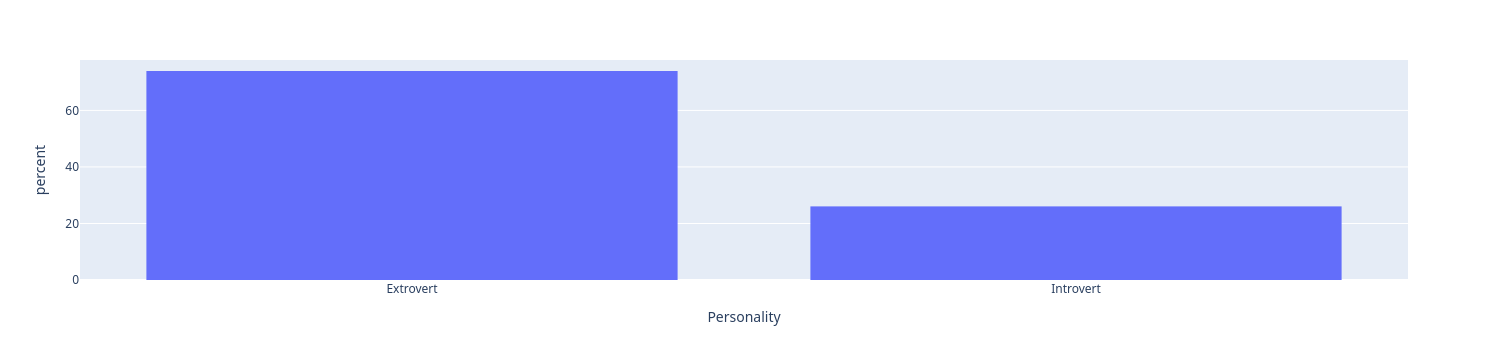

In [6]:
px.histogram(df, x="Personality", histnorm="percent", width=500)

## Time_spent_Alone

- Clear difference between personalities (Extrovert -> lower, Introvert -> higher);
- Introverts have a higher variance;
- Extroverts has some outliers;
- ~6.424% of missing values (models have to deal with missing input);
- Has INTEGRAL dtype (nullable);
    - Represent hours;
    - NULLs could be estimated mean for population (i.e., unbiased/uninformative);

In [7]:
column_summary("Time_spent_Alone")

========== Full ==========
NULLs: 6.424%
       Time_spent_Alone
count           17334.0
mean           3.137764
std            3.003786
min                 0.0
25%                 1.0
50%                 2.0
75%                 4.0
max                11.0
========== Introverts ==========
NULLs: 5.824%
       Time_spent_Alone
count            4544.0
mean           7.051937
std            2.645865
min                 0.0
25%                 5.0
50%                 7.0
75%                 9.0
max                11.0
========== Extroverts ==========
NULLs: 6.636%
       Time_spent_Alone
count           12790.0
mean           1.747146
std            1.537609
min                 0.0
25%                 1.0
50%                 2.0
75%                 3.0
max                11.0


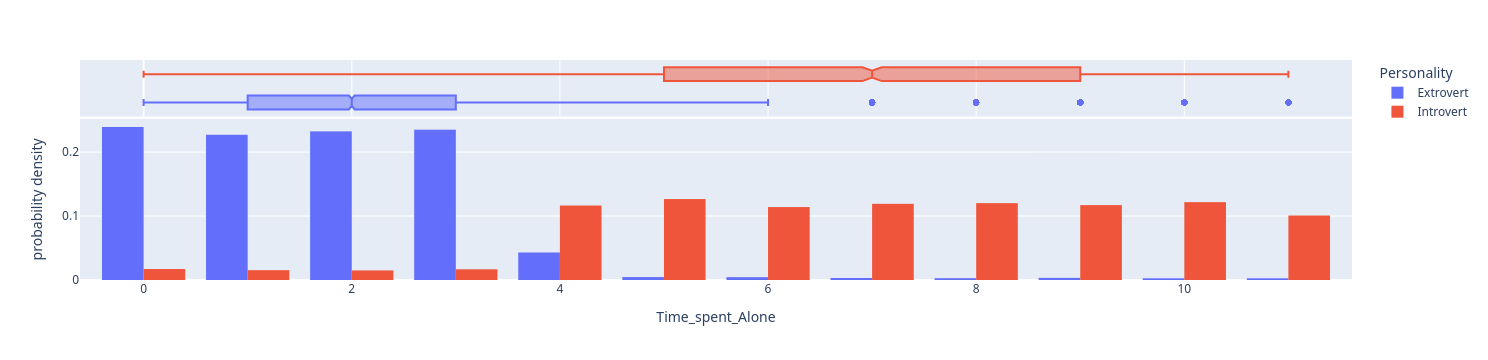

In [8]:
column_personality_histogram("Time_spent_Alone")

## Stage_fear

- Clear difference between personalities (Introvert -> "Yes", Extrovert -> "No");
- ~10% of missing values (models will either have to deal with missing input or don't use this feature);
    - Introverts missing more (~15% vs ~8%);
- Has CATEGORICAL dtype (nullable);
    - Could convert to `[-1..1]`, NULLs become 0;

In [9]:
column_summary("Stage_fear")

========== Full ==========
NULLs: 10.219%
       Stage_fear
count       16631
unique          2
top            No
freq        12609
========== Introverts ==========
NULLs: 15.420%
       Stage_fear
count        4081
unique          2
top           Yes
freq         3786
========== Extroverts ==========
NULLs: 8.387%
       Stage_fear
count       12550
unique          2
top            No
freq        12314


In [10]:
column_personality_histogram("Stage_fear", marginal=None)

## Social_event_attendance

- Clear difference between personalities (Extrovert -> higher, Introvert -> lower);
- Variance seems slightly high;
- Outliers exist;
- ~6% of missing values (models have to deal with missing input);
    - Introverts missing more (~9% vs ~5%);
- Has INTEGRAL dtype (nullable);
  - Since it is a known scale, we should probably change it to 0.0-1.0;
  - NULLs could be estimated mean for population (i.e., unbiased/uninformative);

In [11]:
column_summary("Social_event_attendance")

========== Full ==========
NULLs: 6.370%
       Social_event_attendance
count                  17344.0
mean                  5.265106
std                   2.753359
min                        0.0
25%                        3.0
50%                        5.0
75%                        8.0
max                       10.0
========== Introverts ==========
NULLs: 9.285%
       Social_event_attendance
count                   4377.0
mean                  1.934202
std                   1.761425
min                        0.0
25%                        1.0
50%                        2.0
75%                        3.0
max                       10.0
========== Extroverts ==========
NULLs: 5.343%
       Social_event_attendance
count                  12967.0
mean                   6.38945
std                   2.020741
min                        0.0
25%                        5.0
50%                        6.0
75%                        8.0
max                       10.0


In [12]:
column_personality_histogram("Social_event_attendance")

## Going_outside

- Clear difference between personalities (Extrovert -> higher, Introvert -> lower);
- High variance;
- ~8% of missing values (models have to deal with missing input);
    - Introverts missing more (~10% vs ~7%);
- Has INTEGRAL dtype (nullable);
  - Since it is a known scale, we should probably change it to 0.0-1.0;
  - NULLs could be estimated mean for population (i.e., unbiased/uninformative);

In [13]:
column_summary("Going_outside")

========== Full ==========
NULLs: 7.914%
       Going_outside
count        17058.0
mean        4.044319
std          2.06258
min              0.0
25%              3.0
50%              4.0
75%              6.0
max              7.0
========== Introverts ==========
NULLs: 10.446%
       Going_outside
count         4321.0
mean        1.534136
std         1.513918
min              0.0
25%              0.0
50%              1.0
75%              2.0
max              7.0
========== Extroverts ==========
NULLs: 7.022%
       Going_outside
count        12737.0
mean        4.895894
std         1.434279
min              0.0
25%              4.0
50%              5.0
75%              6.0
max              7.0


In [14]:
column_personality_histogram("Going_outside")

## Drained_after_socializing

- Clear difference between personalities (Introvert -> "Yes", Extrovert -> "No");
- ~6% of missing values (models will either have to deal with missing input or don't use this feature);
    - Introverts missing most (~14% vs ~3%);
- Has CATEGORICAL dtype (nullable);
    - Could convert to `[-1..1]`, NULLs become 0;

In [15]:
column_summary("Drained_after_socializing")

========== Full ==========
NULLs: 6.203%
       Drained_after_socializing
count                      17375
unique                         2
top                           No
freq                       13313
========== Introverts ==========
NULLs: 14.238%
       Drained_after_socializing
count                       4138
unique                         2
top                          Yes
freq                        3826
========== Extroverts ==========
NULLs: 3.373%
       Drained_after_socializing
count                      13237
unique                         2
top                           No
freq                       13001


In [16]:
column_personality_histogram("Drained_after_socializing", marginal=None)

## Friends_circle_size

- Clear difference between personalities (Introvert -> smaller, Extrovert -> higher);
- ~6% of missing values (models will either have to deal with missing input);
    - Introverts missing most (~7% vs ~5%);
- Has INTEGRAL dtype (nullable);
    - NULLs could be estimated mean for population (i.e., unbiased/uninformative);

In [17]:
column_summary("Friends_circle_size")

========== Full ==========
NULLs: 5.690%
       Friends_circle_size
count              17470.0
mean              7.996737
std               4.223484
min                    0.0
25%                    5.0
50%                    8.0
75%                   12.0
max                   15.0
========== Introverts ==========
NULLs: 7.337%
       Friends_circle_size
count               4471.0
mean              3.263923
std               2.649747
min                    0.0
25%                    1.0
50%                    3.0
75%                    4.0
max                   15.0
========== Extroverts ==========
NULLs: 5.110%
       Friends_circle_size
count              12999.0
mean              9.624587
std               3.347242
min                    0.0
25%                    7.0
50%                   10.0
75%                   12.0
max                   15.0


In [18]:
column_personality_histogram("Friends_circle_size")

## Post_frequency

- Clear difference between personalities (Extrovert -> higher, Introvert -> lower);
- High variance;
- ~7% of missing values (models have to deal with missing input);
    - Introverts missing more (~10% vs ~6%);
- Has INTEGRAL dtype (nullable);
  - Since it is a known scale, we should probably change it to 0.0-1.0;
  - NULLs could be estimated mean for population (i.e., unbiased/uninformative);

In [19]:
column_summary("Post_frequency")

========== Full ==========
NULLs: 6.824%
       Post_frequency
count         17260.0
mean         4.982097
std          2.879139
min               0.0
25%               3.0
50%               5.0
75%               7.0
max              10.0
========== Introverts ==========
NULLs: 10.093%
       Post_frequency
count          4338.0
mean         1.611342
std          1.746218
min               0.0
25%               0.0
50%               1.0
75%               2.0
max              10.0
========== Extroverts ==========
NULLs: 5.672%
       Post_frequency
count         12922.0
mean         6.113682
std          2.225713
min               0.0
25%               4.0
50%               6.0
75%               8.0
max              10.0


In [20]:
column_personality_histogram("Post_frequency")